## Importing the required libraries

In [1]:
import pandas as pd
import time
import seaborn as sns
import matplotlib.pyplot as plt

from URLParser import URLParser
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import preprocessing

from sklearn.feature_selection import chi2, SelectKBest
from wordcloud import WordCloud

from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, roc_curve, roc_auc_score

## Importing the dataset

In [2]:
# Importing the dataset
with open('./data/dataset.txt', 'r') as f:
    content = f.read().split('\n\n')[:-1]

tempData = { 'url': [], 'title': [], 'category': []}
for row in content:
    d = row.split('\n')
    tempData['url'].append(d[0])
    tempData['title'].append(d[1])
    tempData['category'].append(d[2])

dataset = pd.DataFrame(tempData, columns = ["url", "title", "category"])


 Group info
category
business      16574
health        17234
politics      15434
sports        17230
technology    14071
dtype: int64


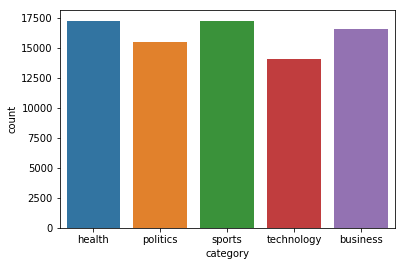

In [3]:
# Raw analysis
print('\n', 'Group info')
print(dataset.groupby('category').size())
# Plot showing number of data entries in each category
sns.countplot(dataset['category'],label="Count")
plt.show()

## Preprocessing

In [4]:
# Creating corpus of words
corpus = []
for i, row in dataset.iterrows():
    pu = URLParser(row['url'], row['title']).getParsedData()
    tok = pu['tokens'] + pu['titleTokens']
    corpus.append(" ".join(tok))

## TF-IDF vectorizer

In [5]:
# Vectorizing the dataset
vectorizer = TfidfVectorizer(ngram_range=(1,5), max_features=10000)
dtm = vectorizer.fit_transform(corpus)
X = pd.DataFrame(dtm.toarray(), columns=vectorizer.get_feature_names())
y = dataset.iloc[:, 2].values

## Label encoder to encode target variable

In [6]:
# Encoding target variable
le = preprocessing.LabelEncoder()
y = le.fit_transform(y)

## Chi2 method to select top k features

In [7]:
# Selecting top features using chi2
sel = SelectKBest(chi2, k=2200).fit(X, y)
X = sel.transform(X)

## Generating a wordcloud from top 120 features

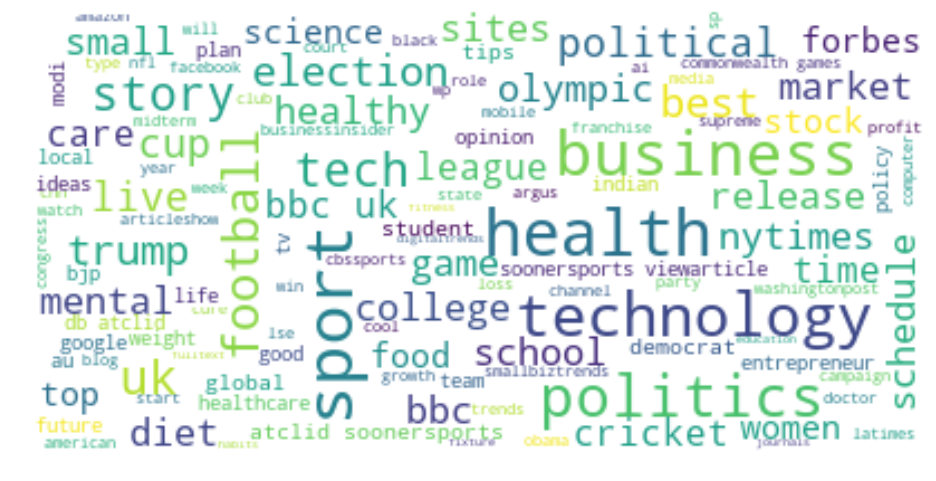

In [8]:
# Generate a wordcloud from top features
mask = sel.get_support()
topFeatures = []

for bool, feature in zip(mask, vectorizer.get_feature_names()):
    if bool:
        topFeatures.append(feature)

topWords = " ".join(topFeatures)
wordcloud = WordCloud(width=1600, height=800).generate(topWords)
plt.figure()
plt.subplots(figsize=(16,9))
wordcloud = WordCloud(background_color="white", max_font_size=30, max_words=120, relative_scaling=0.3).generate(topWords)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()
#wordcloud.to_file("wordcloud.png")

## Splitting the dataset into train and test set

In [9]:
# Splitting the dataset into the Training set and Test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1994)

## Evaluation function

In [10]:
def evaluate(y_pred):
    cm = confusion_matrix(y_test, y_pred)
    print("Confusion matrix:\n%s" % cm)
    print("Accuracy: ", accuracy_score(y_test, y_pred))
    print("\n")
    print(classification_report(y_test, y_pred, target_names=le.classes_))

# Classifiers

## Decision tree classifier

In [11]:
# Decision tree
dtClassifier = DecisionTreeClassifier(random_state=1994, max_depth=60)
startTime = time.time()
dtClassifier.fit(X_train, y_train)
print("Decision Tree training time: %s" % (time.time() - startTime))
startTime = time.time()
y_pred_dt = dtClassifier.predict(X_test)
print("Decision Tree prediction time: %s" % (time.time() - startTime))
evaluate(y_pred_dt)

Decision Tree training time: 84.31812691688538
Decision Tree prediction time: 0.16330599784851074
Confusion matrix:
[[3856   46   80   37  112]
 [ 998 3160   33   25   47]
 [1068   30 2805   18   19]
 [ 814   33   30 3449   28]
 [1228   59   43   30 2088]]
Accuracy:  0.762713547874


             precision    recall  f1-score   support

   business       0.48      0.93      0.64      4131
     health       0.95      0.74      0.83      4263
   politics       0.94      0.71      0.81      3940
     sports       0.97      0.79      0.87      4354
 technology       0.91      0.61      0.73      3448

avg / total       0.85      0.76      0.78     20136



## Naive Bayes classifier

In [12]:
# Naive bayes
nbClassifier = MultinomialNB()
startTime = time.time()
nbClassifier.fit(X_train, y_train)
print("Naive Bayes training time: %s" % (time.time() - startTime))
startTime = time.time()
y_pred_nb = nbClassifier.predict(X_test)
print("Naive Bayes prediction time: %s" % (time.time() - startTime))
evaluate(y_pred_nb)

Naive Bayes training time: 0.3837897777557373
Naive Bayes prediction time: 0.08451199531555176
Confusion matrix:
[[3358  190  232  145  206]
 [ 154 3757  123   97  132]
 [ 149  119 3502  114   56]
 [ 131  150   89 3912   72]
 [ 355  230  109  136 2618]]
Accuracy:  0.851559396106


             precision    recall  f1-score   support

   business       0.81      0.81      0.81      4131
     health       0.85      0.88      0.86      4263
   politics       0.86      0.89      0.88      3940
     sports       0.89      0.90      0.89      4354
 technology       0.85      0.76      0.80      3448

avg / total       0.85      0.85      0.85     20136



## Random forest classifier

In [13]:
# Random Forest
rfClassifier = RandomForestClassifier(n_estimators=50, max_depth=60,
                             random_state=1994, criterion='gini', oob_score=True)
startTime = time.time()
rfClassifier.fit(X_train, y_train)
print("Random forest training time: %s" % (time.time() - startTime))
startTime = time.time()
y_pred_rf = rfClassifier.predict(X_test)
print("Random forest prediction time: %s" % (time.time() - startTime))
evaluate(y_pred_rf)

Random forest training time: 87.62473511695862
Random forest prediction time: 0.5786130428314209
Confusion matrix:
[[3802   44  121   51  113]
 [ 562 3516   69   44   72]
 [ 626   23 3224   30   37]
 [ 504   29   55 3736   30]
 [ 855   75   86   49 2383]]
Accuracy:  0.827423520064


             precision    recall  f1-score   support

   business       0.60      0.92      0.73      4131
     health       0.95      0.82      0.88      4263
   politics       0.91      0.82      0.86      3940
     sports       0.96      0.86      0.90      4354
 technology       0.90      0.69      0.78      3448

avg / total       0.86      0.83      0.83     20136



## K-nearest neighbors

In [14]:
# KNN
knnClassifier = KNeighborsClassifier(n_neighbors=50)
startTime = time.time()
knnClassifier.fit(X_train, y_train)
print("KNN training time: %s" % (time.time() - startTime))
startTime = time.time()
y_pred_knn = knnClassifier.predict(X_test)
print("KNN prediction time: %s" % (time.time() - startTime))
evaluate(y_pred_knn)

KNN training time: 26.87722086906433
KNN prediction time: 3628.262941837311
Confusion matrix:
[[3422   78  359   89  183]
 [ 300 3493  259   89  122]
 [ 250   54 3466  110   60]
 [ 224   73  261 3742   54]
 [ 579  140  279  104 2346]]
Accuracy:  0.817888359158


             precision    recall  f1-score   support

   business       0.72      0.83      0.77      4131
     health       0.91      0.82      0.86      4263
   politics       0.75      0.88      0.81      3940
     sports       0.91      0.86      0.88      4354
 technology       0.85      0.68      0.76      3448

avg / total       0.83      0.82      0.82     20136



## Logit regression classifier

In [15]:
# Logistic regression classifier
lrClassifier = LogisticRegression(random_state=1994, solver='lbfgs', multi_class='multinomial')
startTime = time.time()
lrClassifier.fit(X_train, y_train)
print("Logistic regression training time: %s" % (time.time() - startTime))
startTime = time.time()
y_pred_lr = lrClassifier.predict(X_test)
print("Logistic regression prediction time: %s" % (time.time() - startTime))
evaluate(y_pred_lr)

Logistic regression training time: 49.0171480178833
Logistic regression prediction time: 0.10837697982788086
Confusion matrix:
[[3621   76  169   65  200]
 [ 198 3777  115   63  110]
 [ 169   49 3590   63   69]
 [ 167   59   75 3992   61]
 [ 356  121  110   82 2779]]
Accuracy:  0.881952721494


             precision    recall  f1-score   support

   business       0.80      0.88      0.84      4131
     health       0.93      0.89      0.91      4263
   politics       0.88      0.91      0.90      3940
     sports       0.94      0.92      0.93      4354
 technology       0.86      0.81      0.83      3448

avg / total       0.88      0.88      0.88     20136



## Support Vector Machines classifier

In [16]:
# SVM
svmClassifier = LinearSVC(random_state=1994) #gamma=0.01
startTime = time.time()
svmClassifier.fit(X_train, y_train)
print("SVM training time: %s" % (time.time() - startTime))
startTime = time.time()
y_pred_svm = svmClassifier.predict(X_test)
print("SVM prediction time: %s" % (time.time() - startTime))
evaluate(y_pred_svm)

SVM training time: 1.1779289245605469
SVM prediction time: 0.09998512268066406
Confusion matrix:
[[3633   67  168   62  201]
 [ 185 3801  110   57  110]
 [ 177   42 3608   50   63]
 [ 172   56   78 3985   63]
 [ 351  113  122   67 2795]]
Accuracy:  0.885081446166


             precision    recall  f1-score   support

   business       0.80      0.88      0.84      4131
     health       0.93      0.89      0.91      4263
   politics       0.88      0.92      0.90      3940
     sports       0.94      0.92      0.93      4354
 technology       0.86      0.81      0.84      3448

avg / total       0.89      0.89      0.89     20136



## Plotting ROC curve

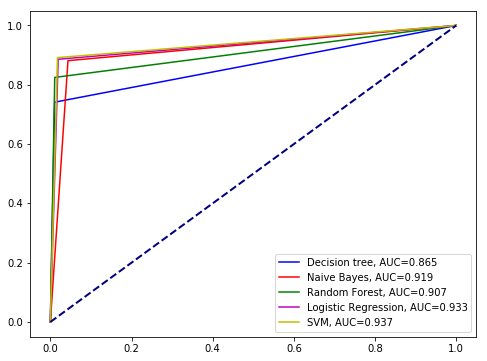

In [17]:
# Plotting the ROC curve
# To plot the ROC curve, we'll have to convert the multiclass classification problem to a OneVsRest problem

y_test = [ i if (i==1) else 0 for i in y_test  ]

plt.figure()
plt.subplots(figsize=(8,6))

y_pred_dt = [ i if (i==1) else 0 for i in y_pred_dt  ]
fpr, tpr, _ = roc_curve(y_test, y_pred_dt, pos_label=1)
plt.plot(fpr, tpr, 'b', label="Decision tree, AUC=" + str(round(roc_auc_score(y_test, y_pred_dt), 3)))

y_pred_nb = [ i if (i==1) else 0 for i in y_pred_nb ]
fpr, tpr, _ = roc_curve(y_test, y_pred_nb)
plt.plot(fpr, tpr, 'r', label="Naive Bayes, AUC=" + str(round(roc_auc_score(y_test, y_pred_nb), 3)))

y_pred_rf = [ i if (i==1) else 0 for i in y_pred_rf  ]
fpr, tpr, _ = roc_curve(y_test, y_pred_rf)
plt.plot(fpr, tpr, 'g', label="Random Forest, AUC=" + str(round(roc_auc_score(y_test, y_pred_rf), 3)))

y_pred_lr = [ i if (i==1) else 0 for i in y_pred_lr  ]
fpr, tpr, _ = roc_curve(y_test, y_pred_lr)
plt.plot(fpr, tpr, 'm', label="Logistic Regression, AUC=" + str(round(roc_auc_score(y_test, y_pred_lr), 3)))

y_pred_svm = [ i if (i==1) else 0 for i in y_pred_svm  ]
fpr, tpr, _ = roc_curve(y_test, y_pred_svm)
plt.plot(fpr, tpr, 'y', label="SVM, AUC=" + str(round(roc_auc_score(y_test, y_pred_svm), 3)))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.legend()
plt.show()